# Welcome to the OceanSpy demo
This is an interactive presentation.  
Use this link to play with the code: https://bndr.it/7dsz
<img src="https://github.com/malmans2/oceanspy/raw/master/docs/_static/oceanspy_logo_blue.png" width="50%" alt="OceanSpy">
Press `F11` for full screen mode.  
Press `space` to move to the next slide.

## What is OceanSpy?
A Python package to facilitate ocean model data analysis and visualization.

## Ocean circulation models are becoming increasingly realistic, producing:
*  Large volumes of data
*  Labelled multi-dimensional arrays
*  Arrays on staggered grids

## Ocean circulation models are becoming increasingly realistic, producing:
* Large volumes of data ⮕ [Dask](https://dask.org/)
* Labelled multi-dimensional arrays ⮕ [xarray](http://xarray.pydata.org/)
* Arrays on staggered grids ⮕ [xgcm](https://xgcm.readthedocs.io/)

### OceanSpy builds on software packages developed by the [Pangeo](https://pangeo.io/) community.
###### Pangeo tutorial @ 15:30

## Why OceanSpy? 
To analyze model data in the way observational oceanographers analyze field measurements.

<figure>
  <img src="https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/bams/2019/15200477-100.9/bams-d-18-0217.1/20190923/images/large/bams-d-18-0217.1-f2.jpeg"
       width="70%" alt="IGP">
  <figcaption>Figure from Renfrew et al., 2019.</figcaption>
</figure>

## How to use OceanSpy?
* Locally.
* On remote data-analysis clusters (e.g., [SciServer](http://www.sciserver.org) or clouds).
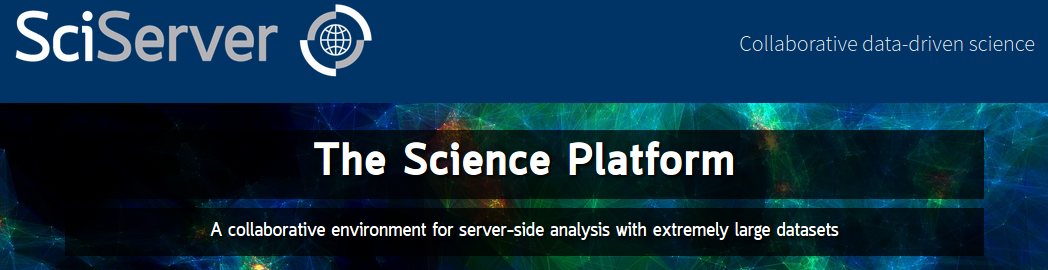

# Demo dataset

<figure>
  <img src="https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/phoc/2017/15200485-47.12/jpo-d-17-0129.1/20171212/images/large/jpo-d-17-0129.1-f1.jpeg"
       width="80%" alt="model">
  <figcaption>Figure from Almansi et al., 2017.</figcaption>
</figure>

Setup

In [ ]:
# Import OceanSpy
import oceanspy as ospy

# Shift+Enter to execute the code.
# Space to continue.

In [ ]:
# Import additional packages and change some defaults
import xarray as xr
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt

xr.set_options(display_style="html")
mpl.rcParams["figure.figsize"] = [10, 5]
mpl.rcParams["font.size"] = 15

# Hide warnings
import warnings

warnings.filterwarnings("ignore")

Open

In [ ]:
# Import OceanDataset
od = ospy.open_oceandataset.from_zarr("OSM2020_EGshelfIIseas2km_ERAI_1D")

# Show OceanDataset
od

xarray's Dataset

In [ ]:
od.dataset

Plot bathymetry

In [ ]:
# Note: Automatically projected using od.projection
ax = od.plot.horizontal_section(varName="Depth")

# Use case: Kögur
<figure>
  <img src="http://kogur.whoi.edu/img/array2.png"
       width="50%" alt="Kogur" style="background-color: #1c4966;">
  <figcaption>From http://kogur.whoi.edu/</figcaption>
</figure>

## OceanSpy mooring array
<figure>
  <img src="https://oceanspy.readthedocs.io/en/latest/_images/Kogur_15_1.png"
       width="70%" alt="Kogur model">
  <figcaption>From https://oceanspy.readthedocs.io/en/latest/Kogur.html</figcaption>
</figure>

Extract mooring array

In [ ]:
# Kögur coordinates
lats_Kogur = [68.68, 67.52, 66.49]
lons_Kogur = [-26.28, -23.77, -22.99]

# Extract mooring array
od_moor = od.subsample.mooring_array(Xmoor=lons_Kogur, Ymoor=lats_Kogur)

Plot moorings

In [ ]:
# Show the array on top of bathymetry
ax = od.plot.horizontal_section(varName="Depth")
X, Y = od_moor.dataset["XC"].squeeze(), od_moor.dataset["YC"].squeeze()
line = ax.plot(X, Y, "r.", transform=ccrs.PlateCarree())

T/S diagram (density needs to be computed!)

In [ ]:
# T/S diagram color-coded by depth (averaged over time).
ax = od_moor.plot.TS_diagram(colorName="Z", meanAxes="time")

Animated T/S diagram

In [ ]:
# Using .animate instead of .plot
anim = od_moor.animate.TS_diagram(colorName="Z")
plt.close()

## OceanSpy ship survey
<figure>
  <img src="https://web.whoi.edu/all0118/wp-content/uploads/sites/129/2019/02/aoY1Qa3w-1024x683.jpeg"
       width="65%" alt="survey">
  <figcaption>From https://web.whoi.edu/all0118</figcaption>
</figure>

Extract ship survey

In [ ]:
# Extract survey overlapping the mooring array
# Note: This function interpolates, getting rid of staggered grids
varList = ["Temp", "S", "U", "V"]
od_surv = od.subsample.survey_stations(
    Xsurv=lons_Kogur, Ysurv=lats_Kogur, delta=2, varList=varList
)

# Change background color
mpl.rcParams["axes.facecolor"] = ".25"

Show vertical section

In [ ]:
# Vertical section of temperature with isopycnals
xr_kwargs = dict(center=False, cmap="Spectral_r")
ax = od_surv.plot.vertical_section(
    varName="Temp", contourName="Sigma0", meanAxes="time", **xr_kwargs
)

Rotate velocities

In [ ]:
# Switch reference system to cross/along-section
od_surv = od_surv.compute.survey_aligned_velocities()

Show through section velocity

In [ ]:
# Animation of velocity orthogonal to the section
anim = od_surv.animate.vertical_section(
    varName="ort_Vel", contourName="Sigma0", **dict(robust=True)
)
plt.close()

# OceanSpy diagnostics overview
<figure>
  <img src="https://github.com/malmans2/ospy-rise-binder/raw/master/joss_table.png"
       width="55%" alt="JOSStable">
  <figcaption>Table from Almansi et al., 2019.</figcaption>
</figure>

Compute Ertel PV: $\displaystyle{Q = - \frac{\omega \cdot \nabla \rho}{\rho}  =}\displaystyle{(f + \zeta)\frac{N^2}{g} + \frac{\left(\zeta_H+e\hat{\mathbf{y}}\right)\cdot\nabla_H\rho}{\rho_0}}$

In [ ]:
# Compute Ertel PV in the top 100m
od100m = od.subsample.cutout(ZRange=[0, -100])
od100m = od100m.compute.Ertel_potential_vorticity()

Show Ertel PV evolution

In [ ]:
# Plot Ertel PV (averaged over Z).
# Note: The vertical mean is automatically weighted.
# Important because the vertical resolution of this model varies!
anim = od100m.animate.horizontal_section(
    varName="Ertel_PV",
    meanAxes="Z",
    **dict(robust=True, center=False, cmap="inferno"),
)
plt.close()

# More info:
* OceanSpy documentation: https://oceanspy.readthedocs.io
* OceanSpy GitHub: https://github.com/malmans2/oceanspy
* JOSS paper: https://doi.org/10.21105/joss.01506
* SciServer: http://www.sciserver.org
* Poseidon project: TODO!